# Project 1 - Rice Leaf Disease Prediction

# AIM 
### ● Create a model which can classify the three major attacking diseases of rice plants like leaf smut, bacterial blight and brown spot.
#####


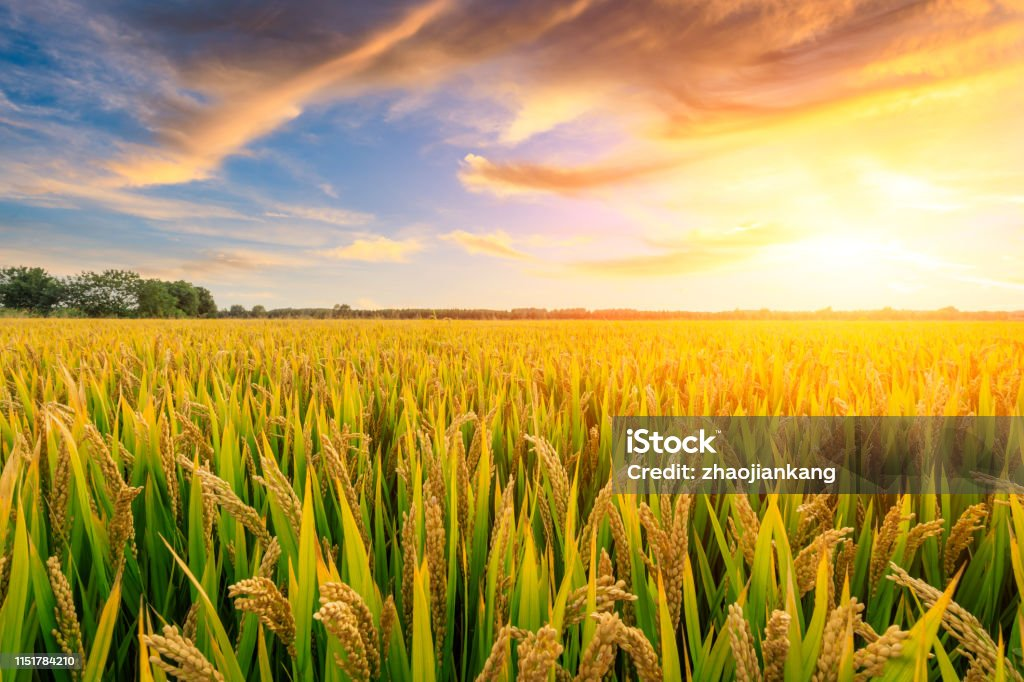

In [4]:
from IPython.display import Image
Image("istockphoto-1151784210-1024x1024.jpg")

# 1. Import Library

In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [7]:
BATCH_SIZE = 12
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\\Users\\HP\\Downloads\\PRCP-1001-RiceLeaf\\Data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 119 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(12, 256, 256, 3)
[0 1 0 0 2 1 1 0 0 1 1 2]


# 2. Domain Analysis

## This dataset contains 119 jpg images of disease-infected rice leaves. The images are grouped into 3 classes based on the type of disease. There are 40 images in each class.
### ●  Classes
####  1.  Leaf smut
####  2. Brown spot
####  3. Bacterial leaf blight

# 3.Visualize some of the images from our dataset

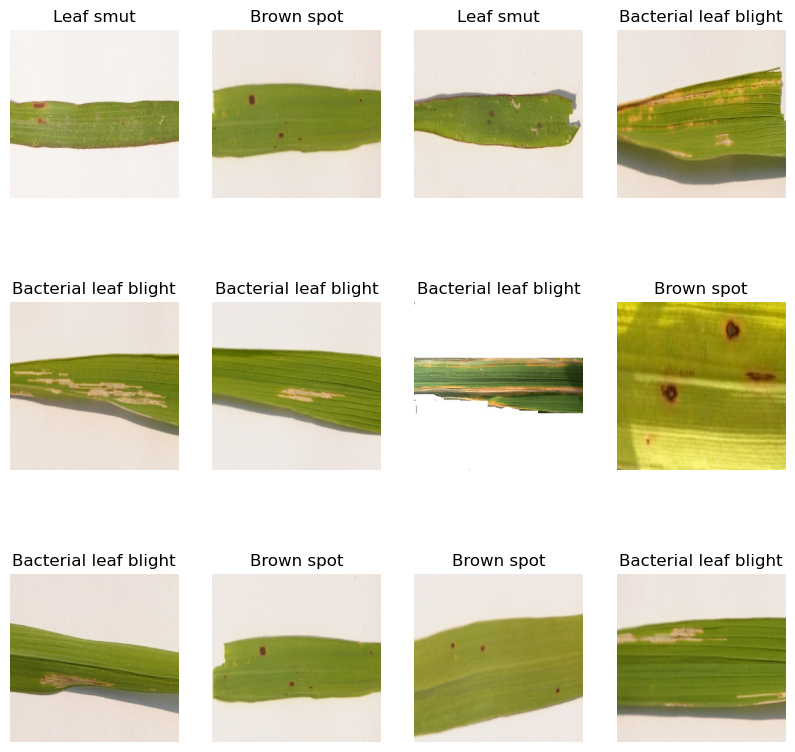

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# 4. Spliting 

In [ ]:
Dataset can be splited into further category:-
80% ==> training
20% ==> test
    10% = validation, this we can use for measure epoch accuracy 
    10% = testing

In [8]:
len(dataset)

10

In [9]:
train_size = 0.8
len(dataset)*train_size

8.0

In [10]:
# Training 
train_ds = dataset.take(8)
len(train_ds)

8

In [11]:
test_ds = dataset.skip(8)
len(test_ds)

2

In [12]:
val_size=0.1
len(dataset)*val_size

1.0

In [13]:
# Validation 
val_ds = test_ds.take(1)
len(val_ds)

1

In [14]:
# Testing 
test_ds = test_ds.skip(1)
len(test_ds)

1

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

8

In [18]:
len(val_ds)

1

In [19]:
len(test_ds)

1

# 5. Data Preprocessing

## ● Cache, Shuffle, and Prefetch the Dataset

In [20]:
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)

## ● Resize and Rescale 

In [58]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## ● Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [59]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Applying Data Augmentation to Train Dataset

In [60]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



# 6. Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [61]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape) 

In [62]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (12, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (12, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (12, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (12, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (12, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (12, 60, 60, 64)         

# 7. Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [63]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [64]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
8/8 [==============================] - 13s 1s/step - loss: 1.1420 - accuracy: 0.3854 - val_loss: 1.0874 - val_accuracy: 0.5833
Epoch 2/50
8/8 [==============================] - 9s 1s/step - loss: 1.0946 - accuracy: 0.3750 - val_loss: 1.0412 - val_accuracy: 0.5833
Epoch 3/50
8/8 [==============================] - 10s 1s/step - loss: 1.1047 - accuracy: 0.3646 - val_loss: 1.0642 - val_accuracy: 0.5833
Epoch 4/50
8/8 [==============================] - 10s 1s/step - loss: 1.0992 - accuracy: 0.3646 - val_loss: 1.0834 - val_accuracy: 0.5833
Epoch 5/50
8/8 [==============================] - 10s 1s/step - loss: 1.0958 - accuracy: 0.3646 - val_loss: 1.0786 - val_accuracy: 0.5833
Epoch 6/50
8/8 [==============================] - 10s 1s/step - loss: 1.0951 - accuracy: 0.3646 - val_loss: 1.0682 - val_accuracy: 0.5833
Epoch 7/50
8/8 [==============================] - 10s 1s/step - loss: 1.0946 - accuracy: 0.3646 - val_loss: 1.0476 - val_accuracy: 0.5833
Epoch 8/50
8/8 [===================

In [65]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 0s 320ms/step - loss: 0.3507 - accuracy: 0.9167


In [66]:
scores

[0.3506576120853424, 0.9166666865348816]

In [67]:
history

In [68]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 8}

In [69]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [70]:
type(history.history['loss'])

list

In [71]:
len(history.history['loss'])

50

In [72]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.1420401334762573,
 1.0946305990219116,
 1.1046568155288696,
 1.0992381572723389,
 1.0957881212234497]

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

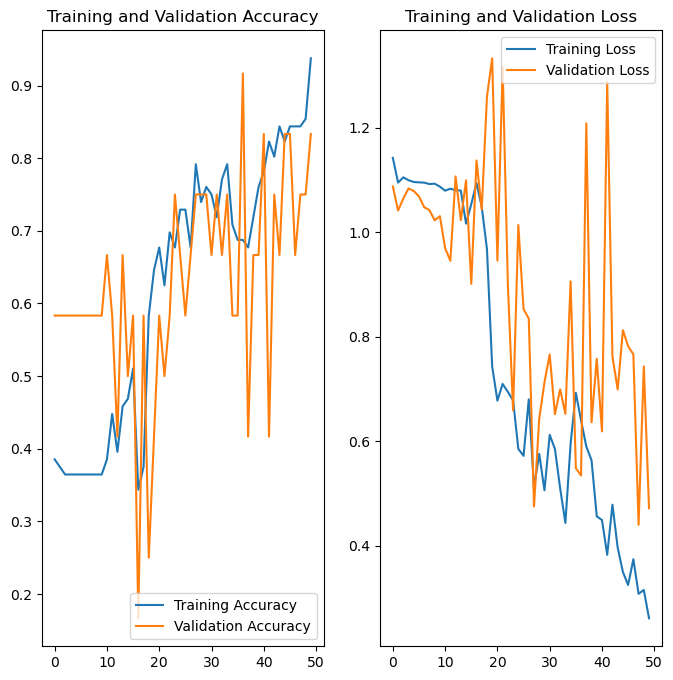

In [75]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 8.  Run prediction on a sample image

first image to predict
actual label: Bacterial leaf blight
1/1 [==============================] - 0s 475ms/step
predicted label: Bacterial leaf blight


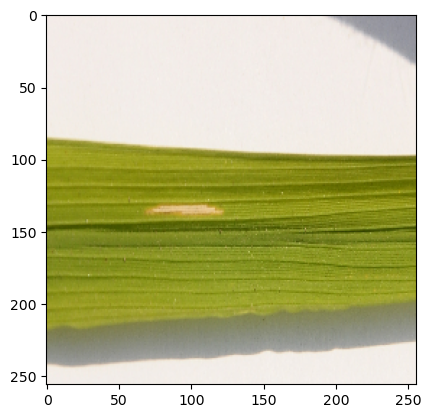

In [76]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# 9. Model Prediction

In [77]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 62ms/step


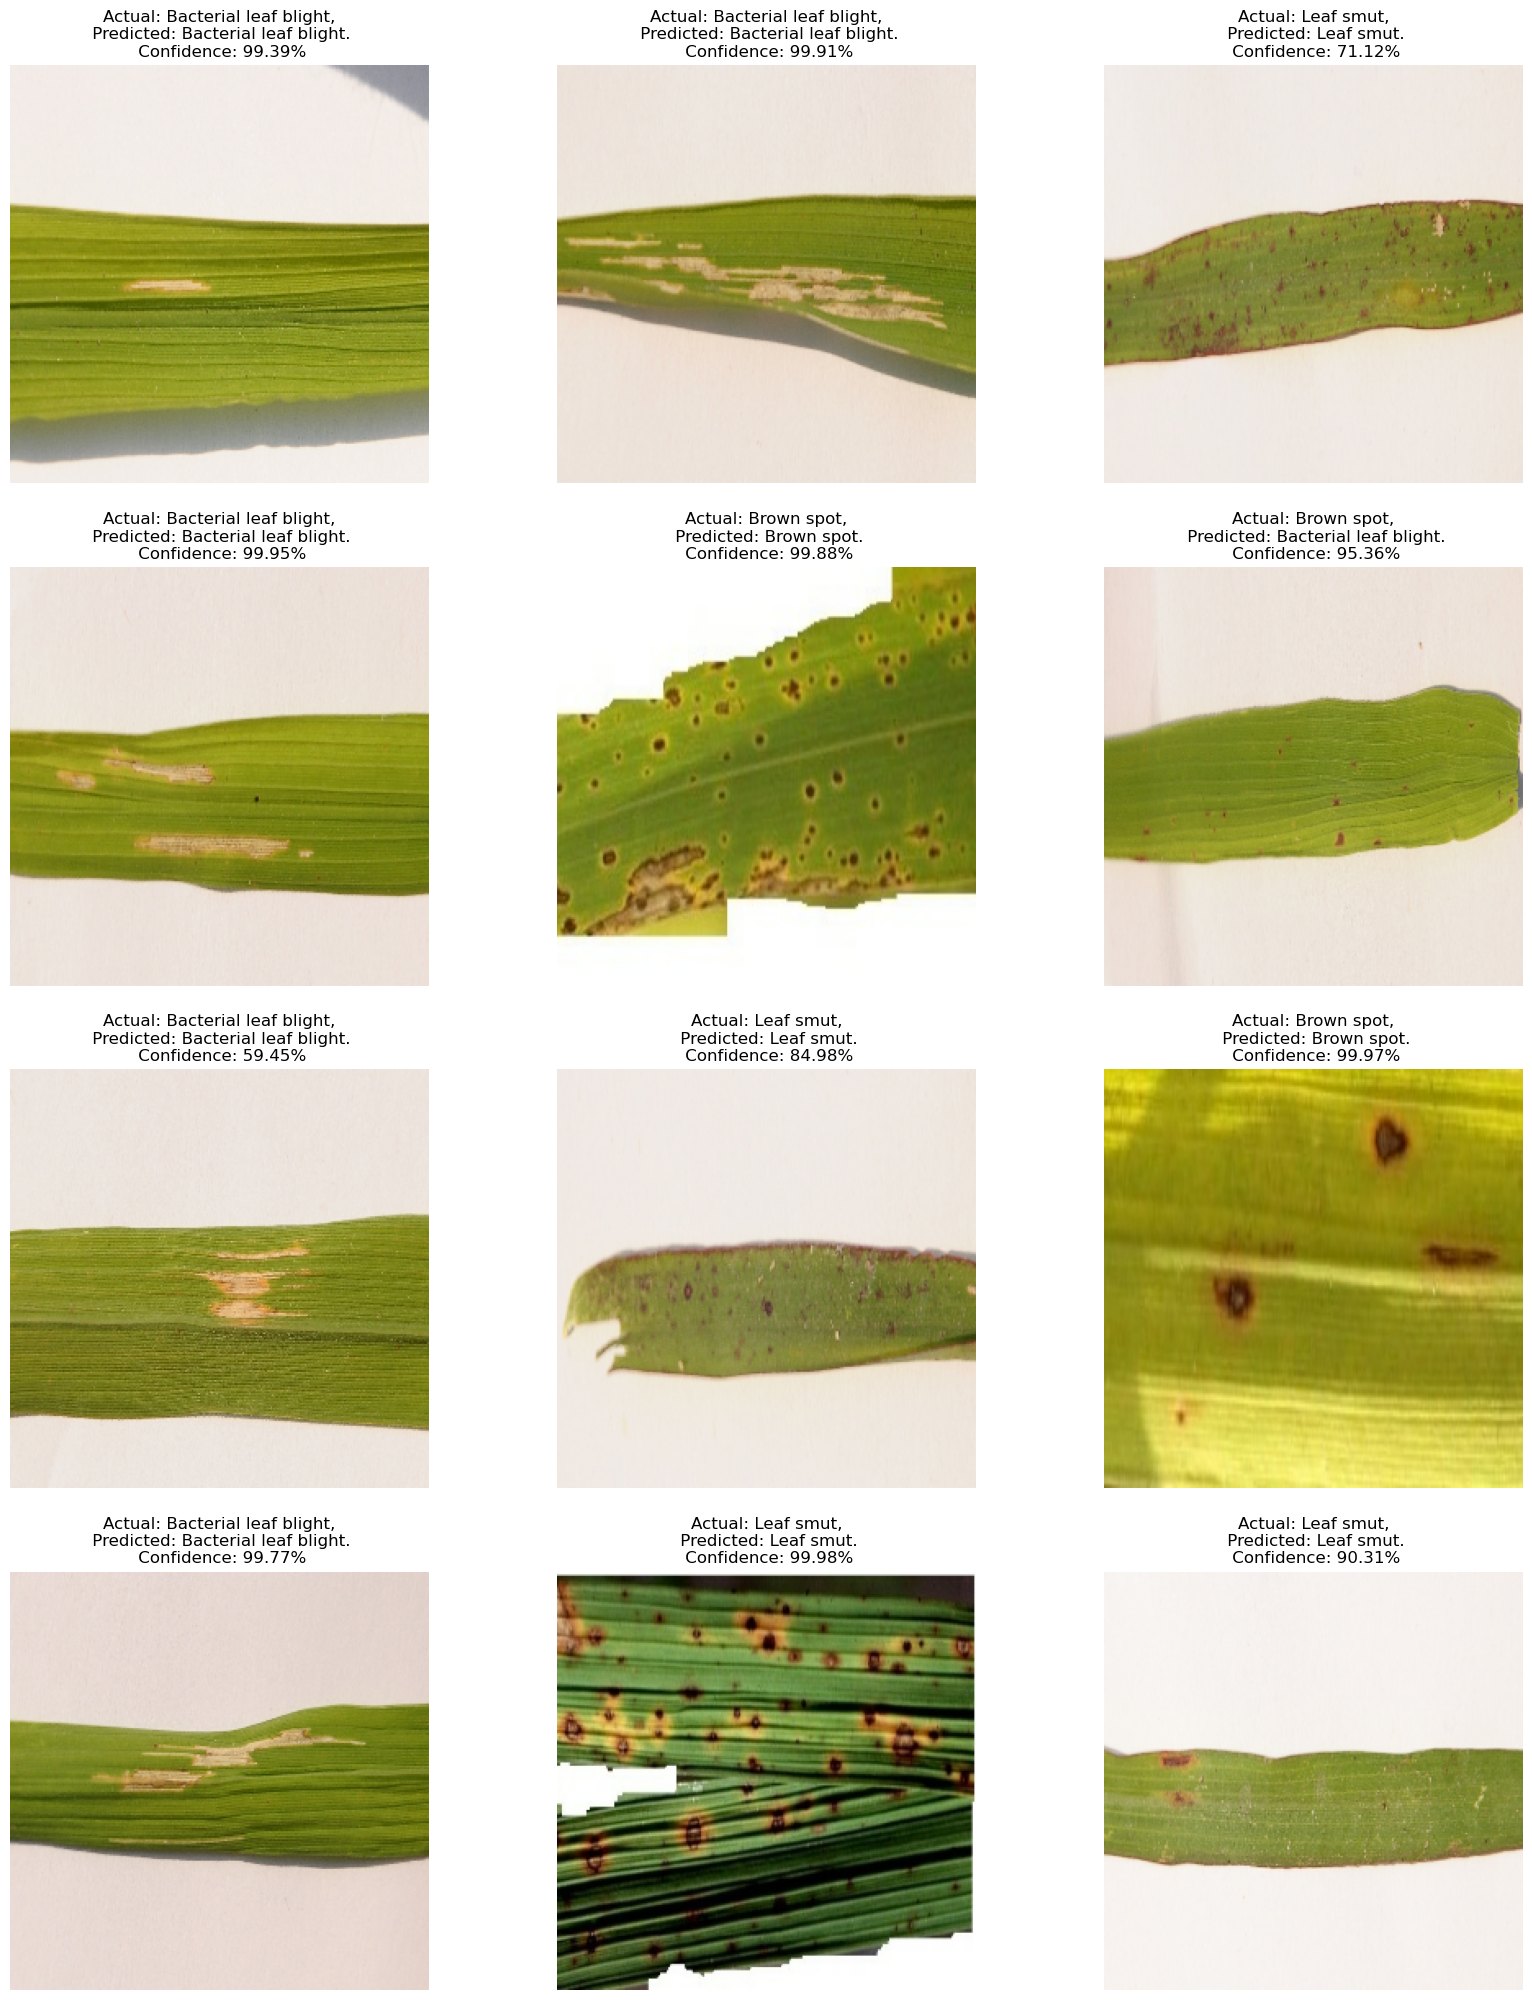

In [79]:
plt.figure(figsize=(20, 25))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# conclusion
In our project, we successfully developed a deep learning model that accurately predicts rice leaf diseases, marking a significant achievement in agricultural technology. This model has proven to be highly effective, consistently making correct predictions during testing. Its practical application is particularly beneficial for farmers, as it greatly aids in the early identification of diseases in rice crops.

